<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA6-Phase1/blob/main/05-Coding-Drill-Down/MNIST_Classification_Model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Digit classification 

CNN model for image classification.

Target:
1. Previous model was showing over-fitting tendency. We will try to reduce the gap between test and train accuracy by regularizing the model with dropouts.

Results:
1. With dropout of 0.05 added at each layer, overfitting is reduced.
2. Training accuracy of 99.42% and test accuracy of 99.49%

Analysis:
1. Overfitting tendency which was observed in previous model has been reduced.
2. Model is still quite heavy compared to the 8K parameter requirement. From observation, at RF=5x5 itself useful patterns are formed. Hence, we will remove the 3rd 3x3 conv layer before maxpooling.


## Necessary packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

!pip install torchsummary
from torchsummary import summary
from torchvision import transforms, datasets, utils

## Prepare dataset

In [ ]:
train_transform = transforms.Compose([
                                    #   transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])
test_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

In [ ]:
train_dataset = datasets.MNIST(root='../data', train=True, transform=train_transform, download=True)
test_dataset = datasets.MNIST(root='../data', train=False, transform=test_transform, download=True)

In [ ]:
sample = next(iter(train_dataset))
data, label = sample
print(data.shape, type(data))

torch.Size([1, 28, 28]) <class 'torch.Tensor'>


Dataloader

In [ ]:
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, **kwargs)

In [ ]:
sample_images, sample_labels = next(iter(train_loader))
print(sample_images[:16].shape)

torch.Size([16, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 117, 117])


(-0.5, 116.5, 116.5, -0.5)

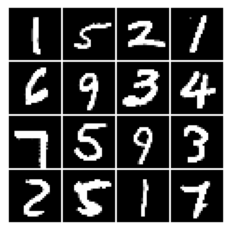

In [ ]:
grid_image = utils.make_grid(sample_images[:16], nrow=4, padding=1, pad_value=1)
print(grid_image.shape)
plt.imshow(grid_image.permute(1,2,0))
plt.axis('off')

## CNN model

In [ ]:
# Object Recognition
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)                        
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)                         
        )
        # Maxpooling
        self.pool1 = nn.MaxPool2d(2, 2) 
        # TRANSITION BLOCK 1
        self.transitionblock1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)                        
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)                        
        )
       
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)                        
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)                        
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )

        self.translinear = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1, padding=0, bias=False),
            )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.transitionblock1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.translinear(x)
        x = x.view(-1, 10)
        return x 


In [ ]:
use_cuda = torch.cuda.is_available()
# hid_dim =
device = torch.device("cuda" if use_cuda else "cpu")
print("Available device:",device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]           2,304
             ReLU-10           [-1, 16, 28, 28]               0
      BatchNorm2d-11           [-1, 16, 28, 28]              32
          Dropout-12           [-1, 16, 28, 28]               0
        MaxPool2d-13           [-1, 16, 14, 14]               0
           Conv2

## Train and Test

In [ ]:
# Train

def train(model, device, train_loader, optimizer, criterion):
    model.train()

    # collect stats - for accuracy calculation
    correct = 0
    processed = 0
    batch_loss = 0
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_id, batch in enumerate(train_loader):
        data = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()

        # Gather prediction and calculate loss + backward pass + optimize weights
        label_pred = model(data)
        label_loss = criterion(label_pred, target)
        # Calculate gradients
        label_loss.backward()
        # Optimizer
        optimizer.step()

        # Metrics calculation- For epoch Accuracy(total correct pred/total items) and loss 
        pred = label_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        epoch_loss += label_loss.item()
    
    epoch_accuracy = (100*correct/processed)
    epoch_loss /= len(train_loader)
    print(f"Train set: Epoch Accuracy: {round(epoch_accuracy, 2)}  Epoch Loss: {round(epoch_loss, 4)}")

    return epoch_accuracy, epoch_loss

In [ ]:
# Test
def test(model, device, test_loader, criterion):
    model.eval()

    # collect stats - for accuracy calculation
    correct = 0
    processed = 0
    batch_loss = 0
    epoch_loss = 0
    epoch_accuracy = 0

    with torch.no_grad():        
        for batch_id, batch in enumerate(test_loader):
            data = batch[0].to(device)
            target = batch[1].to(device)

            label_pred = model(data)
            label_loss = criterion(label_pred, target)

            # Metrics calculation
            pred = label_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
            epoch_loss += label_loss.item()
        
    epoch_accuracy = (100*correct)/processed
    epoch_loss /= len(test_loader)
    print(f"Test set: Epoch Accuracy: {round(epoch_accuracy, 2)}  Epoch Loss: {round(epoch_loss, 4)}")
    return epoch_accuracy, epoch_loss

## Model training and Validation

In [ ]:
EPOCHS = 15
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []

# Optimization algorithm from torch.optim
optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
# Loss condition
criterion = nn.CrossEntropyLoss()

for epochs in range(EPOCHS):
    print(f"Epoch: {epochs}")
    train_acc_delta, train_loss_delta = train(model, device, train_loader, optimizer, criterion)
    test_acc_delta, test_loss_delta = test(model, device, test_loader, criterion)

    train_accuracy.append(round(train_acc_delta, 2))
    train_loss.append(round(train_loss_delta, 4))
    test_accuracy.append(round(test_acc_delta, 2))
    test_loss.append(round(test_loss_delta, 4))

Epoch: 0
Train set: Epoch Accuracy: 92.98  Epoch Loss: 0.2445
Test set: Epoch Accuracy: 98.05  Epoch Loss: 0.0624
Epoch: 1
Train set: Epoch Accuracy: 98.3  Epoch Loss: 0.0543
Test set: Epoch Accuracy: 99.07  Epoch Loss: 0.0342
Epoch: 2
Train set: Epoch Accuracy: 98.8  Epoch Loss: 0.0401
Test set: Epoch Accuracy: 99.3  Epoch Loss: 0.0225
Epoch: 3
Train set: Epoch Accuracy: 98.89  Epoch Loss: 0.0351
Test set: Epoch Accuracy: 99.12  Epoch Loss: 0.0282
Epoch: 4
Train set: Epoch Accuracy: 98.98  Epoch Loss: 0.0312
Test set: Epoch Accuracy: 99.31  Epoch Loss: 0.0213
Epoch: 5
Train set: Epoch Accuracy: 99.13  Epoch Loss: 0.0285
Test set: Epoch Accuracy: 99.31  Epoch Loss: 0.0218
Epoch: 6
Train set: Epoch Accuracy: 99.16  Epoch Loss: 0.0262
Test set: Epoch Accuracy: 99.24  Epoch Loss: 0.0226
Epoch: 7
Train set: Epoch Accuracy: 99.26  Epoch Loss: 0.0238
Test set: Epoch Accuracy: 99.34  Epoch Loss: 0.0213
Epoch: 8
Train set: Epoch Accuracy: 99.32  Epoch Loss: 0.022
Test set: Epoch Accuracy: 99.3

<Figure size 432x288 with 0 Axes>

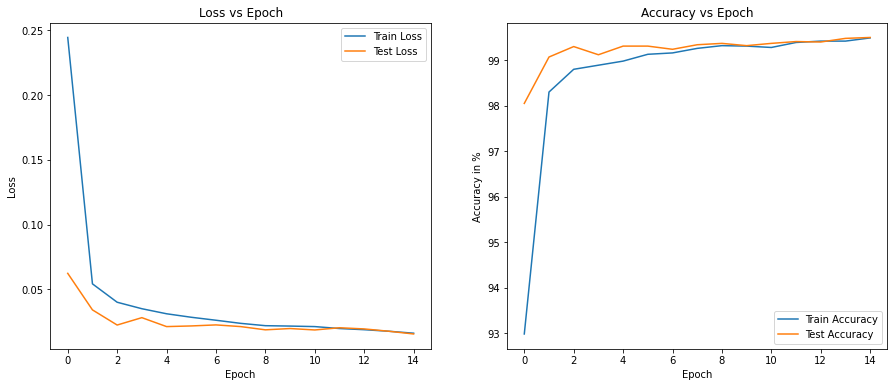

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].plot(train_loss, label="Train Loss")
axs[0].plot(test_loss, label = "Test Loss")
axs[0].set_title("Loss vs Epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="best")

axs[1].plot(train_accuracy, label="Train Accuracy")
axs[1].plot(test_accuracy, label="Test Accuracy")
axs[1].set_title("Accuracy vs Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy in %")
axs[1].legend(loc="best")

plt.figure()